## Attribution classification (VOD, file download, etc...)
Our way for the classification is based on a research of: G. Draper-Gil, A. H. Lashkari, M. S. I. Mamun, and A. A. Ghorbani,
“Characterization of encrypted and VPN traffic using time-related features” in Proc. 2nd Int. Conf. Inf. Syst. Security Privacy, vol. 1, 2016, pp. 407–414

or in this link
https://www.scitepress.org/papers/2016/57407/57407.pdf

In this research they tried to do attribute classification by machine learning. 
They recommended to take time-based features.
From the aritcle:
1) duration - The duration of the flow.
2) fiat - Forward Inter Arrival Time the time between two packets sent forward direction (mean, min, max, std).
3) biat - Backward Inter Arrival Time the time between two packets sent backwards (mean, min, max, std).
4) flowiat - Flow Inter Arrival Time the time between two packets sent in either direction (mean, min, max, std).
5) active - The amount of time time a flow was active before going idle (mean, min, max, std).
6) idle - The amount of time time a flow was idle before becoming active (mean, min, max, std).
7) fb psec - Flow Bytes per second.
8) fp psec - Flow packets per second.

This in addition to the Source ip, Source port, Destination ip, Destination port, Timestamp

We've took those feature and in addition we've looked on more researches that did attribution classification from the *"vpn non-vpn ISCX 2016"* dataset and tried to understand what the feature to use.
Most of them focused in the same features if we working with machine learning.


In [1]:
# # Installation if needed

# !pip install pandas
# !pip install numpy
# !pip install sklearn
# !pip install matplotlib
# !pip install seaborn

In [1]:
# library imports 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load train, test, and validation datasets
# train_path = '../attribution/train.csv'
# test_path = '../attribution/test.csv'
# val_path = '../attribution/val_without_labels.csv'

train_path = 'train.csv'
test_path = 'test.csv'
val_path = 'val_without_labels.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
validation_data = pd.read_csv(val_path)

In [3]:
train_df.head()

,Source_IP,Source_port,Destination_IP,Destination_port,Protocol,Timestamp,fwd_packets_amount,bwd_packets_amount,fwd_packets_length,bwd_packets_length,...,beaconning_15,beaconning_16,beaconning_17,beaconning_18,beaconning_19,pps_fwd,pps_bwd,count_big_requests,ACK_count,attribution
0,10.10.0.127,55263,185.226.55.159,443,tcp,1.728384e+09,1061,2652,45,82,...,0,0,0,0,0,50.768460,92.511416,3,126,VOD
1,10.10.0.127,58102,185.226.53.133,443,tcp,1.728387e+09,1002,1960,18,78,...,0,0,0,0,0,51.756576,224.278494,2,95,VOD
2,10.100.102.20,60582,82.166.22.12,443,tcp,1.726548e+09,357,467,9,9,...,0,0,0,0,0,0.149860,0.149860,2,17,VOD
3,10.100.102.20,51682,82.166.78.13,443,udp,1.726546e+09,501,698,422,548,...,0,0,0,0,0,45.721665,59.373157,10,963,VOD
4,10.100.102.20,54683,209.85.165.170,443,udp,1.726531e+09,97,114,24,26,...,0,0,0,0,0,21.900107,23.725116,5,50,VOD


In [4]:
# # Prepare features and target
# y_train = train_df['attribution']
# y_test = test_df['attribution']

In [5]:
# # Encode labels
label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)
# Add attribution encoder here
attribution_encoder = LabelEncoder()
attribution_encoder.fit(['VOD', 'file download', 'real_time_audio', 'real_time_messaging', 'real_time_video'])

# Prepare features and target
y_train = train_df['attribution']
y_test = test_df['attribution']

# Use attribution_encoder instead of label_encoder here
y_train_encoded = attribution_encoder.transform(y_train)
y_test_encoded = attribution_encoder.transform(y_test)

In [6]:
X_train = X_train = train_df.drop(columns='attribution')
X_test = test_df.drop(columns='attribution')

X_train.shape


(25, 111)

In [7]:
# col_to_stay = [
#     # 'Source_IP',
#     'Destination_IP',
#     'Timestamp',
#     'Destination_port',
#     'Source_port',
#     'fwd_packets_amount','bwd_packets_amount','fwd_packets_length','bwd_packets_length','max_fwd_packet ','min_fwd_packet','max_bwd_packet','min_bwd_packet','min_fwd_inter_arrival_time','max_fwd_inter_arrival_time','mean_fwd_inter_arrival_time','min_bwd_inter_arrival_time','max_bwd_inter_arrival_time','mean_bwd_inter_arrival_time','min_bib_inter_arrival_time','max_bib_inter_arrival_time','mean_bib_inter_arrival_time','min_packet_size','max_packet_size' ,'mean_packet_size','pps_fwd','pps_bwd'
# ]
# # #['min_fwd_inter_arrival_time',	'max_fwd_inter_arrival_time','mean_fwd_inter_arrival_time','min_bwd_inter_arrival_time','max_bwd_inter_arrival_time',	'mean_bwd_inter_arrival_time','min_bib_inter_arrival_time',	'max_bib_inter_arrival_time','mean_bib_inter_arrival_time']
# # #['min_packet_size','max_packet_size','mean_packet_size']
# # #['STD_packet_size','mean_delta_byte','STD_delta_byte'] reducing to 84 %
# # #['pps_fwd','pps_bwd']

# # Subset the DataFrames
# X_train = train_df[col_to_stay]
# X_test = test_df[col_to_stay]

In [8]:
col_to_stay = [
    "Timestamp",
    "Source_port",
    "Destination_IP",
    "Destination_port",
    "Protocol",
    "fwd_packets_amount",
    "bwd_packets_amount",
    "fwd_packets_length",
    "bwd_packets_length",
    "max_fwd_packet ",
    "min_fwd_packet",
    "max_bwd_packet",
    "min_bwd_packet",
    "min_fwd_inter_arrival_time",
    "max_fwd_inter_arrival_time",
    "mean_fwd_inter_arrival_time",
    "min_bwd_inter_arrival_time",
    "max_bwd_inter_arrival_time",
    "mean_bwd_inter_arrival_time",
    "mean_bib_inter_arrival_time",
    "FIN_count",
    "SYN_count",
    "RST_count",
    "PSH_count",
    "ACK_count",
    "min_packet_size",
    "max_packet_size",
    "mean_packet_size",
    "STD_packet_size",
    "pps_fwd",
    "pps_bwd",
]
X_train = train_df[col_to_stay]
X_test = test_df[col_to_stay]

In [9]:
X_train.shape

(25, 31)

In [10]:
# IP-based features
def ip_to_int(ip):
    try:
        parts = [int(part) for part in ip.split('.')]
        return parts[0] * 256**3 + parts[1] * 256**2 + parts[2] * 256 + parts[3]
    except:
        return 0

In [11]:
def transform_ip(df):
    df['Destination_IP_num'] = df['Destination_IP'].apply(ip_to_int)

In [12]:
transform_ip(X_train)
transform_ip(X_test)

In [13]:
X_train_drop = X_train.drop(columns=['Destination_IP'])
X_test_drop = X_test.drop(columns=['Destination_IP'])

In [14]:
# Identify columns with string data
string_columns = X_train_drop.select_dtypes(include=['object', 'string']).columns

print(string_columns)

# Initialize a dictionary to store LabelEncoders
label_encoders = {}

# Apply LabelEncoder to each string column in both X_train and X_test
for column in string_columns:
    
    # Fit on X_train and transform both X_train and X_test
    X_train_drop[column] = label_encoder.fit_transform(X_train_drop[column])
    X_test_drop[column] = label_encoder.transform(X_test_drop[column])
    
    # Store the encoder for future reference
    label_encoders[column] = label_encoder

Index(['Protocol'], dtype='object')


In [15]:
# Find columns with non-numeric data in X_test
non_numeric_columns = X_test_drop.select_dtypes(include=['object', 'string']).columns

# Print the non-numeric columns
print("Non-numeric columns in X_test:")
print(non_numeric_columns)

Non-numeric columns in X_test:
Index([], dtype='object')


In [16]:
for column in non_numeric_columns:
    if column in label_encoders:  # Check if this column was encoded in X_train
        le = label_encoders[column]
        X_test_drop[column] = le.transform(X_test_drop[column])
    else:
        print(f"Warning: {column} was not encoded in X_train!")

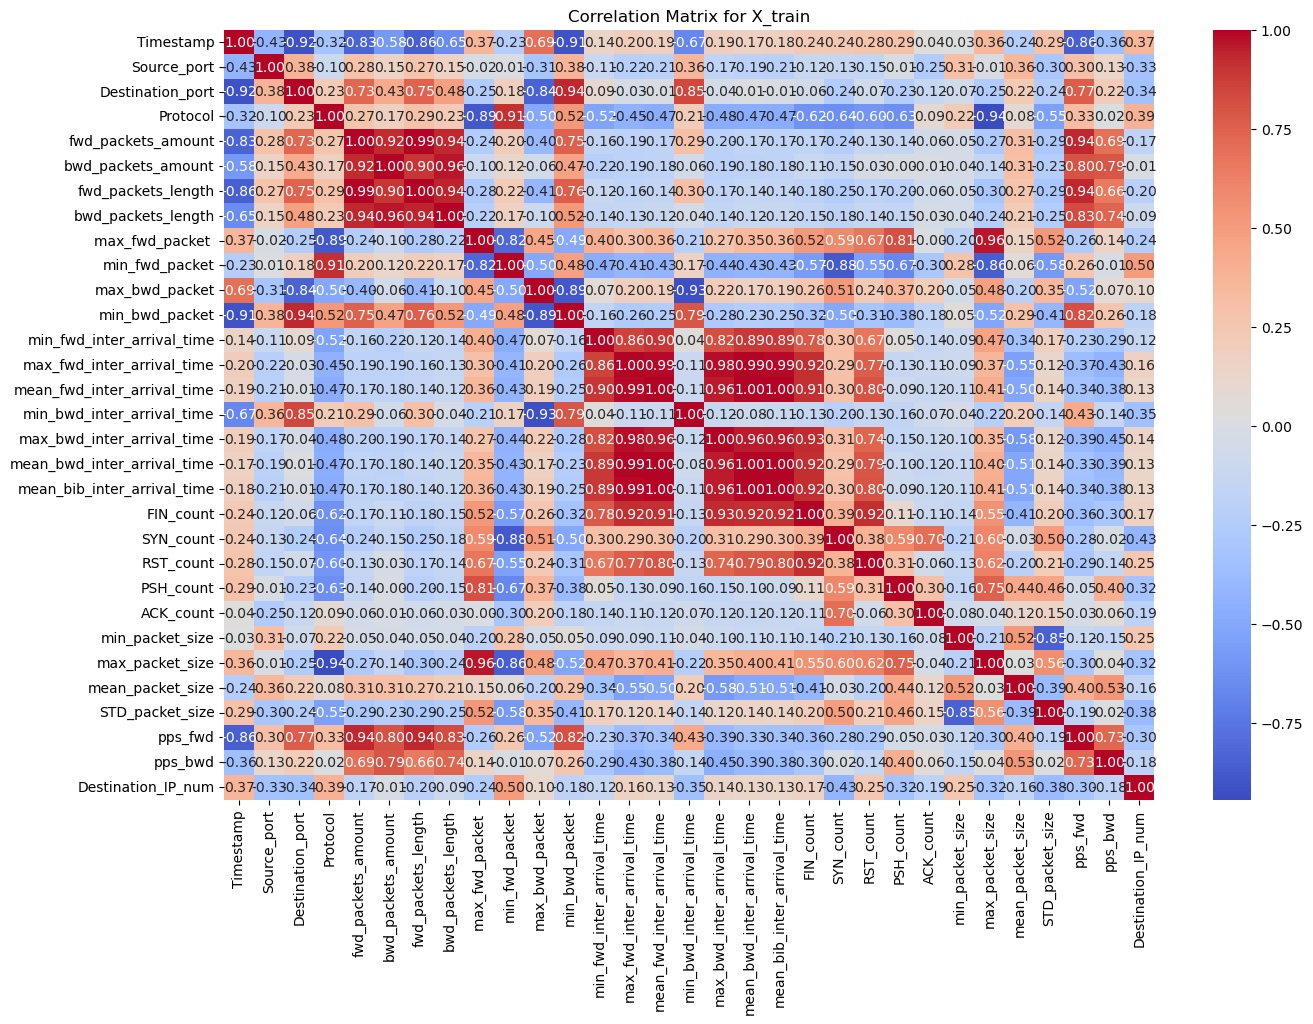

In [17]:
# Correlation matrix of X_train after selected features

# Calculate the correlation matrix
correlation_matrix = X_train_drop.corr()

# Display the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix for X_train")
plt.show()

In [18]:
# Reducing similar features

# Calculate the correlation matrix
correlation_matrix = X_train_drop.corr().abs()  # Absolute value of correlations

# Set the threshold for dropping features
threshold = 0.95

# Create an empty set to hold features to drop
features_to_drop = set()

# Iterate through the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > threshold:
            colname = correlation_matrix.columns[j]
            features_to_drop.add(colname)  # Add one of the features to drop

# Drop the identified features
X_train_reduced = X_train_drop.drop(columns=features_to_drop)
X_test_reduced = X_test_drop.drop(columns=features_to_drop)
# Print the dropped features
print(f"Dropped features: {features_to_drop}")
print(f"Remaining features: {X_train_reduced.columns.tolist()}")

Dropped features: {'max_bwd_inter_arrival_time', 'bwd_packets_length', 'mean_bwd_inter_arrival_time', 'mean_bib_inter_arrival_time', 'mean_fwd_inter_arrival_time', 'max_packet_size', 'fwd_packets_length'}
Remaining features: ['Timestamp', 'Source_port', 'Destination_port', 'Protocol', 'fwd_packets_amount', 'bwd_packets_amount', 'max_fwd_packet ', 'min_fwd_packet', 'max_bwd_packet', 'min_bwd_packet', 'min_fwd_inter_arrival_time', 'max_fwd_inter_arrival_time', 'min_bwd_inter_arrival_time', 'FIN_count', 'SYN_count', 'RST_count', 'PSH_count', 'ACK_count', 'min_packet_size', 'mean_packet_size', 'STD_packet_size', 'pps_fwd', 'pps_bwd', 'Destination_IP_num']


In [19]:
X_test_reduced.shape

(25, 24)

In [20]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

In [21]:
# # Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_drop)
# X_test_scaled = scaler.transform(X_test_drop)

In [22]:
# BaggingClassifier with DecisionTree as base estimator
bagging_clf = BaggingClassifier(random_state=73, n_estimators=150)#,max_samples=0.75, max_features=0.55) # random_state = 9,max_samples=0.8, max_features=0.8 # random_state = 9 ,max_samples=0.75, max_features=0.55
bagging_clf.fit(X_train_scaled, y_train_encoded)
y_pred_bagging = bagging_clf.predict(X_test_scaled)
accuracy_bagging = accuracy_score(y_test_encoded, y_pred_bagging)
print(f"BaggingClassifier Accuracy on Test Dataset: {accuracy_bagging:.4f}")
print("Classification Report (BaggingClassifier):\n", classification_report(y_test_encoded, y_pred_bagging))

BaggingClassifier Accuracy on Test Dataset: 0.9200
Classification Report (BaggingClassifier):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.80      0.80      0.80         5
           3       1.00      1.00      1.00         5
           4       0.80      0.80      0.80         5

    accuracy                           0.92        25
   macro avg       0.92      0.92      0.92        25
weighted avg       0.92      0.92      0.92        25



In [23]:
# Changing seed for accuracy

# highest_accuracy = 0
# best_seed = None

# for seed in range(1, 301):
#     # Initialize BaggingClassifier with the current seed
#     bagging_clf = BaggingClassifier(random_state=seed, n_estimators=150)#,max_samples=0.75, max_features=0.55)
    
#     # Fit the model
#     bagging_clf.fit(X_train_scaled, y_train_encoded)
    
#     # Predict on the test set
#     y_pred_bagging = bagging_clf.predict(X_test_scaled)
    
#     # Calculate accuracy
#     accuracy_bagging = accuracy_score(y_test_encoded, y_pred_bagging)

#     # Update the highest accuracy and corresponding seed if current accuracy is better
#     if accuracy_bagging > highest_accuracy:
#         highest_accuracy = accuracy_bagging
#         best_seed = seed

# # Output the highest accuracy and its corresponding seed
# print(f"Highest Accuracy: {highest_accuracy:.4f} with Seed: {best_seed}")

In [24]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators = 100) # or seed = 9
rf.fit(X_train_scaled, y_train_encoded)
y_pred_rf = rf.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)
print(f"RadomForest Accuracy on Test Dataset: {accuracy_rf:.4f}")
print("Classification Report (RadomForest):\n", classification_report(y_test_encoded, y_pred_rf))

RadomForest Accuracy on Test Dataset: 0.9200
Classification Report (RadomForest):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.80      0.80      0.80         5
           3       1.00      1.00      1.00         5
           4       0.80      0.80      0.80         5

    accuracy                           0.92        25
   macro avg       0.92      0.92      0.92        25
weighted avg       0.92      0.92      0.92        25



In [25]:
from sklearn.ensemble import ExtraTreesClassifier

# Extra Trees Classifier
et = ExtraTreesClassifier(random_state=3, n_jobs=-1, n_estimators=100)
et.fit(X_train_scaled, y_train_encoded)
y_pred_et = et.predict(X_test_scaled)

accuracy_et = accuracy_score(y_test_encoded, y_pred_et)
print(f"ExtraTrees Accuracy on Test Dataset: {accuracy_et:.4f}")
print("Classification Report (ExtraTrees):\n", classification_report(y_test_encoded, y_pred_et))


ExtraTrees Accuracy on Test Dataset: 0.9200
Classification Report (ExtraTrees):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.80      0.80      0.80         5
           3       1.00      1.00      1.00         5
           4       0.80      0.80      0.80         5

    accuracy                           0.92        25
   macro avg       0.92      0.92      0.92        25
weighted avg       0.92      0.92      0.92        25



## Confusion matrix

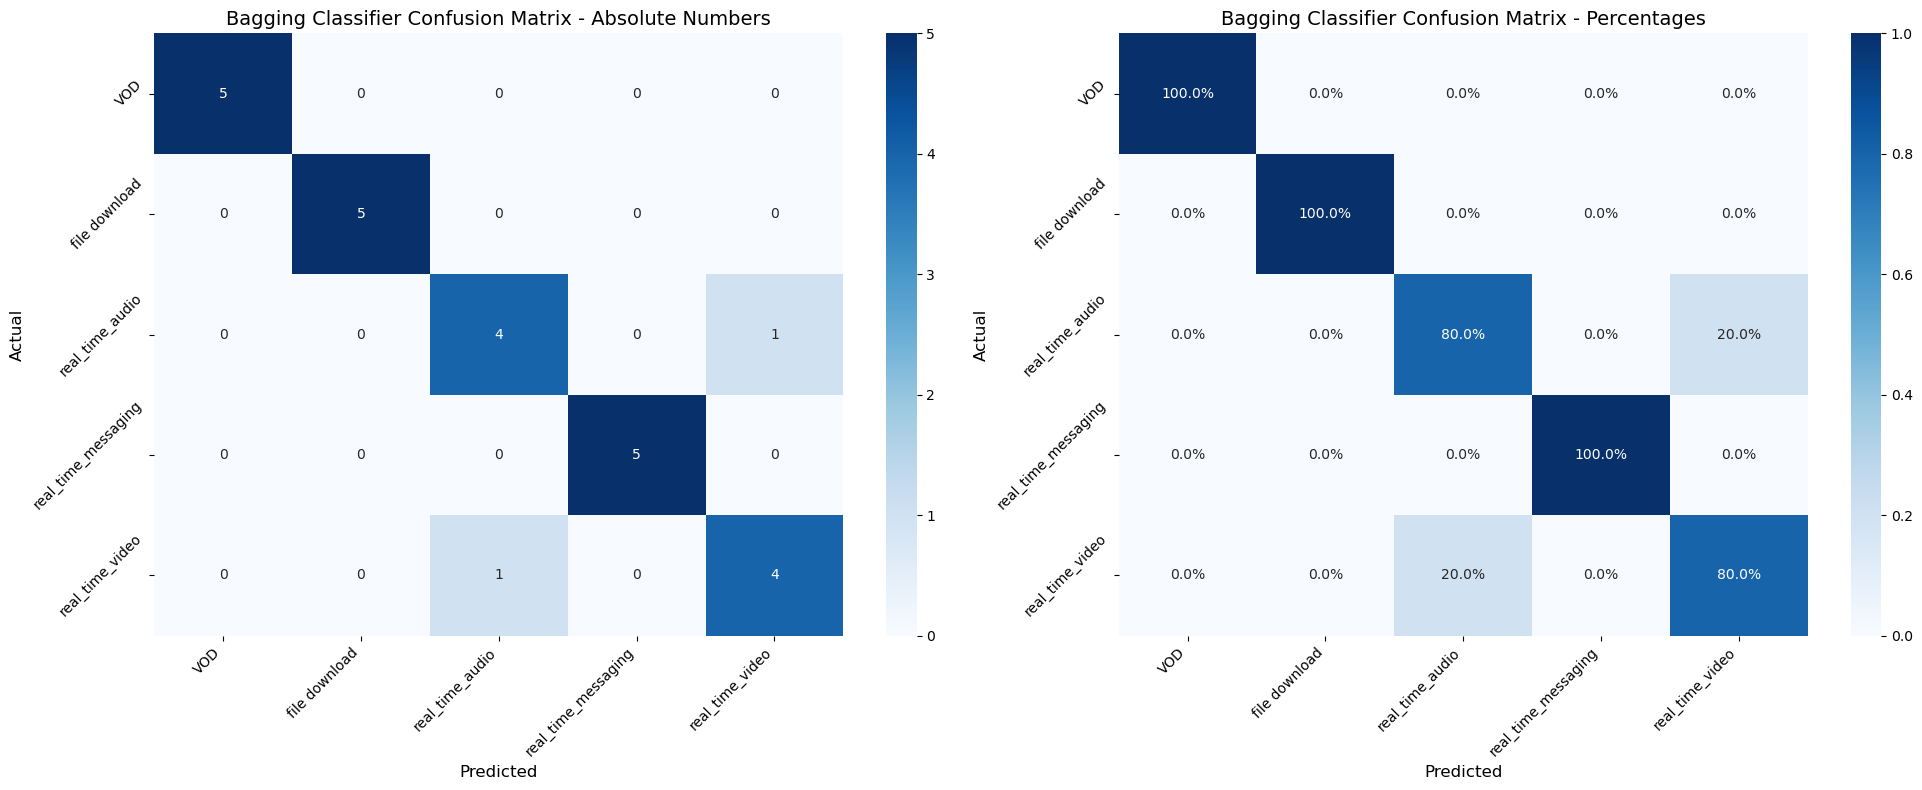


Per-class Classification Report:
                     precision    recall  f1-score   support

                VOD       1.00      1.00      1.00         5
      file download       1.00      1.00      1.00         5
    real_time_audio       0.80      0.80      0.80         5
real_time_messaging       1.00      1.00      1.00         5
    real_time_video       0.80      0.80      0.80         5

           accuracy                           0.92        25
          macro avg       0.92      0.92      0.92        25
       weighted avg       0.92      0.92      0.92        25



In [26]:
#Define class labels in order
class_labels = ['VOD', 'file download', 'real_time_audio', 'real_time_messaging', 'real_time_video']

# Create confusion matrix for bagging classifier results
cm = confusion_matrix(y_test_encoded, y_pred_bagging)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot absolute numbers
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            ax=ax1)
ax1.set_title('Bagging Classifier Confusion Matrix - Absolute Numbers', fontsize=14)
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=45, ha='right')

# Plot percentages
sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            ax=ax2)
ax2.set_title('Bagging Classifier Confusion Matrix - Percentages', fontsize=14)
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('Actual', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print classification metrics per class
print("\nPer-class Classification Report:")
print(classification_report(y_test_encoded, y_pred_bagging, 
                          target_names=class_labels))

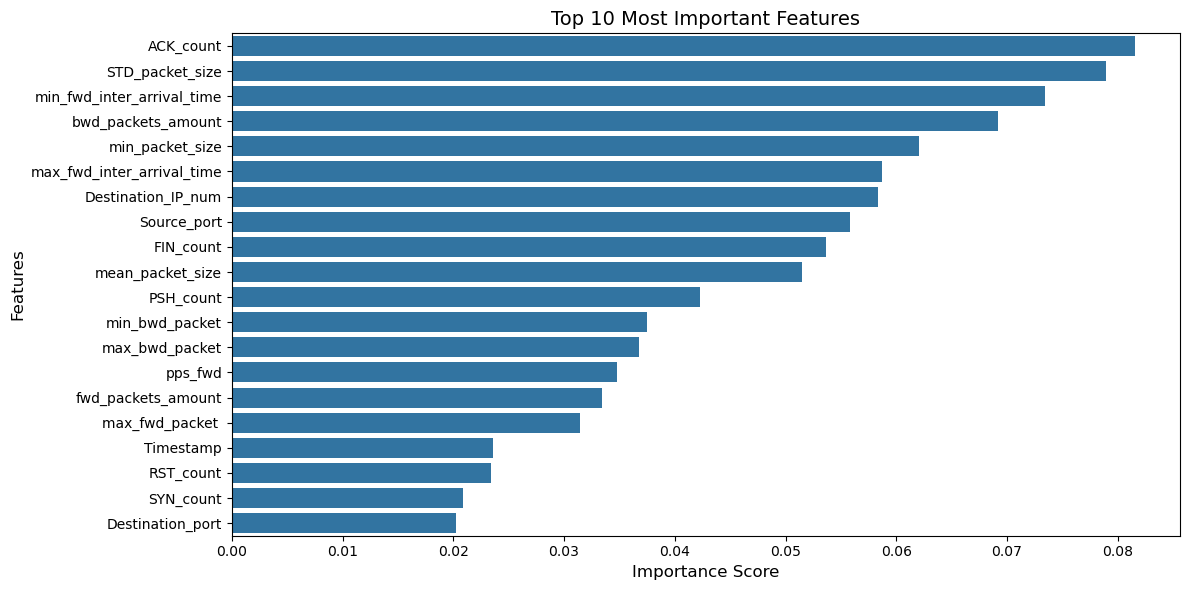

In [27]:
# Feature importance analysis
# Get feature names from the original dataframe before scaling
# feature_names = X_train_drop.columns.tolist()
feature_names = X_train_reduced.columns.tolist()

# Create DataFrame with feature importances
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance - top 10
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=importances.head(20))
plt.title('Top 10 Most Important Features', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Saving model
saving our trained model so can be used next

In [28]:
# Save both the model and necessary encoders/scalers
import os

# After training but before validation
model_save_path = 'attribution_model/'
os.makedirs(model_save_path, exist_ok=True)

joblib.dump(bagging_clf, model_save_path + 'bagging_clf.joblib')
joblib.dump(attribution_encoder, model_save_path + 'attribution_encoder.joblib')
joblib.dump(scaler, model_save_path + 'scaler.joblib')
joblib.dump(label_encoders, model_save_path + 'label_encoders.joblib')

# Later, to load and predict:
bagging_clf = joblib.load(model_save_path + 'bagging_clf.joblib')
attribution_encoder = joblib.load(model_save_path + 'attribution_encoder.joblib')
scaler = joblib.load(model_save_path + 'scaler.joblib')
label_encoders = joblib.load(model_save_path + 'label_encoders.joblib')

## Prediction on the validation

In [29]:
validation_data.head()

,Source_IP,Source_port,Destination_IP,Destination_port,Protocol,Timestamp,fwd_packets_amount,bwd_packets_amount,fwd_packets_length,bwd_packets_length,...,beaconning_14,beaconning_15,beaconning_16,beaconning_17,beaconning_18,beaconning_19,pps_fwd,pps_bwd,count_big_requests,ACK_count
0,10.100.102.20,55556,173.194.24.8,443,udp,1726542931,645,810,23,23,...,0,0,0,0,0,0,20.107761,20.107761,5,46
1,10.100.102.20,62873,173.194.187.71,443,udp,1726541787,862,1086,23,25,...,0,0,0,0,0,0,8.973588,9.753900,5,48
2,10.10.0.127,55592,95.142.206.162,443,tcp,1728384182,56,155,792,1457,...,0,0,0,0,0,0,531.729528,978.194346,3,2248
3,192.168.1.23,63848,13.226.2.66,443,tcp,1728098376,15812,23815,15812,23816,...,0,0,0,0,0,0,262.408637,395.239318,30,39627
4,10.10.0.127,58144,185.226.52.197,443,tcp,1728386965,108,192,6,6,...,0,0,0,0,0,0,29.449143,29.449143,2,11


In [30]:
# Process validation data and make predictions
# First, prepare the validation data the same way as training data
val_processed = validation_data[col_to_stay].copy()
val_processed.shape

(6249, 31)

In [31]:
# Dropping according to the correlation matrix
val_processed = val_processed.drop(columns=features_to_drop)
val_processed.shape

(6249, 24)

In [32]:
# Previous code remains the same until the predictions part
transform_ip(val_processed)
val_processed_drop = val_processed.drop(columns=['Destination_IP'])

# Encode string columns
for column in string_columns:
    if column in label_encoders:
        val_processed_drop[column] = label_encoders[column].transform(val_processed_drop[column])

# Scale the features
val_scaled = scaler.transform(val_processed_drop)

# Make predictions and transform using attribution_encoder
val_predictions_encoded = bagging_clf.predict(val_scaled)
val_predictions = attribution_encoder.inverse_transform(val_predictions_encoded)
rf_val_pred_encoded = rf.predict(val_scaled)
rf_val_pred = attribution_encoder.inverse_transform(rf_val_pred_encoded)
et_val_pred_encoded = et.predict(val_scaled)
et_val_pred = attribution_encoder.inverse_transform(et_val_pred_encoded)

# Create a function for majority voting
def get_majority_vote(pred1, pred2, pred3):
    """
    Implements majority voting with first prediction (bagging) as tiebreaker
    pred1: bagging classifier prediction (used as tiebreaker)
    pred2: random forest prediction
    pred3: extra trees prediction
    """
    final_predictions = []
    
    for p1, p2, p3 in zip(pred1, pred2, pred3):
        # Create a list of predictions for current instance
        predictions = [p1, p2, p3]
        
        # Count occurrences of each prediction
        from collections import Counter
        count = Counter(predictions)
        
        # Get the most common prediction and its count
        most_common = count.most_common(1)[0]
        
        if most_common[1] >= 2:
            # If any prediction appears 2 or more times, use that
            final_predictions.append(most_common[0])
        else:
            # If all predictions are different, use the bagging classifier prediction (p1)
            final_predictions.append(p1)
    
    return final_predictions

# Apply majority voting
final_predictions = get_majority_vote(val_predictions, rf_val_pred, et_val_pred)

# Save all predictions including the final ensemble prediction
validation_data['bagging_predicted_attribution'] = val_predictions
validation_data['rf_predicted_attribution'] = rf_val_pred
validation_data['et_predicted_attribution'] = et_val_pred
validation_data['final_predicted_attribution'] = final_predictions

# Save to CSV
validation_data.to_csv('validation_with_predictions.csv', index=False)

# Create and save a CSV with only the final predictions
final_predictions_df = pd.DataFrame({
    'final_predicted_attribution': final_predictions
})
final_predictions_df.to_csv('final_attribution_predictions.csv', index=False)

# Print distribution of predictions for all classifiers including final ensemble
print("\nDistribution of predicted classes:")
print("\nBagging Classifier predictions:")
print(validation_data['bagging_predicted_attribution'].value_counts())
print("\nRandom Forest predictions:")
print(validation_data['rf_predicted_attribution'].value_counts())
print("\nExtra Trees predictions:")
print(validation_data['et_predicted_attribution'].value_counts())
print("\nFinal Ensemble predictions:")
print(validation_data['final_predicted_attribution'].value_counts())

# Optional: Calculate agreement statistics
total_predictions = len(final_predictions)
unanimous = sum(1 for p1, p2, p3 in zip(val_predictions, rf_val_pred, et_val_pred) 
                if p1 == p2 == p3)
majority = sum(1 for p1, p2, p3 in zip(val_predictions, rf_val_pred, et_val_pred) 
               if len(set([p1, p2, p3])) == 2)
split_decision = total_predictions - unanimous - majority

print(f"\nAgreement Statistics:")
print(f"Unanimous decisions: {unanimous} ({unanimous/total_predictions*100:.2f}%)")
print(f"Majority decisions: {majority} ({majority/total_predictions*100:.2f}%)")
print(f"Split decisions (using bagging): {split_decision} ({split_decision/total_predictions*100:.2f}%)")


Distribution of predicted classes:

Bagging Classifier predictions:
bagging_predicted_attribution
VOD                    3329
file download           955
real_time_video         925
real_time_audio         800
real_time_messaging     240
Name: count, dtype: int64

Random Forest predictions:
rf_predicted_attribution
VOD                    3250
real_time_video        1208
file download           879
real_time_audio         612
real_time_messaging     300
Name: count, dtype: int64

Extra Trees predictions:
et_predicted_attribution
VOD                    3332
real_time_video        1125
file download           910
real_time_audio         706
real_time_messaging     176
Name: count, dtype: int64

Final Ensemble predictions:
final_predicted_attribution
VOD                    3264
real_time_video        1152
file download           911
real_time_audio         650
real_time_messaging     272
Name: count, dtype: int64

Agreement Statistics:
Unanimous decisions: 4766 (76.27%)
Majority decisions